<a href="https://colab.research.google.com/github/rakshith291/Transformer_classification/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)


17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 Training sequences
25000 Validation sequences


In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [5]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
ou = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(ou)

model = keras.Model(inputs=inputs, outputs=[outputs])


In [6]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
ou = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(ou)

model = keras.Model(inputs=inputs, outputs=[outputs])


In [7]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=3, validation_data=(x_val, y_val)
)


Epoch 1/3
782/782 [==============================] - 104s 130ms/step - loss: 0.4019 - accuracy: 0.8035 - val_loss: 0.2950 - val_accuracy: 0.8770
Epoch 2/3
782/782 [==============================] - 102s 131ms/step - loss: 0.2028 - accuracy: 0.9238 - val_loss: 0.3153 - val_accuracy: 0.8734
Epoch 3/3
782/782 [==============================] - 100s 128ms/step - loss: 0.1314 - accuracy: 0.9546 - val_loss: 0.4517 - val_accuracy: 0.8546


In [8]:
# In order to get all weights of the network 
for layer in model.layers :
  print(layer)
  weights = layer.get_weights()
  for weight in range(len(weights)):  # In order to get the weight matrix of all layers inside a block 
    print(weights[weight].shape)
    print(weights[weight])

(20000, 32)
[[-1.32011781e-02  1.31420391e-02 -1.11056035e-02 ...  7.50399474e-03
  -3.72588111e-05  1.12557905e-02]
 [ 2.67275367e-02 -8.07611346e-02 -8.13658535e-02 ... -3.31917405e-02
  -1.59768909e-02 -8.05019587e-02]
 [-3.49713750e-02  3.65832746e-02 -4.59529720e-02 ...  2.96736490e-02
  -8.13563121e-04 -3.75286164e-03]
 ...
 [ 5.24429493e-02 -1.37161706e-02 -1.92983150e-02 ...  1.82476512e-03
  -2.51893885e-02 -8.14184919e-02]
 [-8.30780715e-02  7.33590126e-02  1.47799719e-02 ...  1.14605971e-01
   2.62354165e-02  7.79731497e-02]
 [-6.71764538e-02  4.17828709e-02  3.96053456e-02 ...  5.50180525e-02
   3.99840735e-02  8.72463956e-02]]
(200, 32)
[[-0.04229445 -0.01848471  0.02224793 ... -0.00082316 -0.02887479
   0.02907787]
 [-0.04891696  0.01597684  0.01425143 ... -0.03039492 -0.00477563
   0.02933959]
 [ 0.00317484  0.05757958  0.04012128 ...  0.00382767 -0.01783793
   0.02795759]
 ...
 [-0.02678502 -0.02698834  0.02493715 ...  0.02398885 -0.03281903
  -0.03802811]
 [ 0.02573161

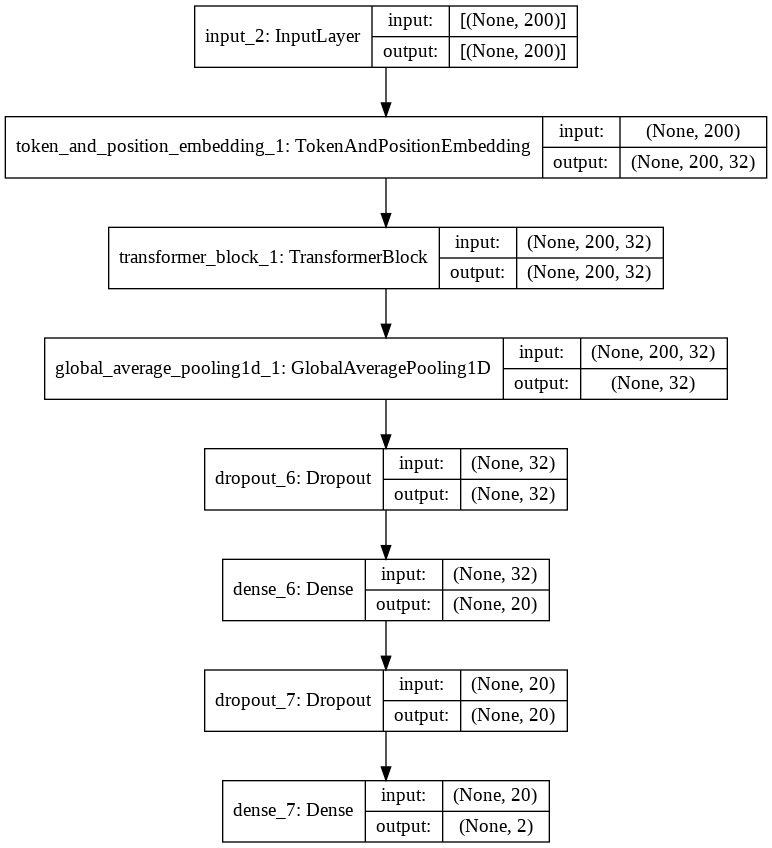

In [9]:
# In order to get layer names with shapes , convinient than model.summary() at times 
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True)

In [11]:
# In order to tap the output after  a particular layer 
layer_name = "transformer_block_1"
intermediate_layer = keras.Model(inputs=model.input,
                        outputs = model.get_layer(layer_name).output)
out_ = intermediate_layer(x_train[14].reshape(1,-1)) # single examplw from the input , reshaping depends on the shape set for i/p layer
print(out_.shape)
# If you want to tap after between layer inside a block (subclass) then implement only that block using functional api 

(1, 200, 32)


In [19]:
# if you want to implement a layer by over-writing the class  
class customMultiAttention(layers.MultiHeadAttention): # class which we are over-writing 
  def __init__(self,num_heads,key_dim) :
    super(customMultiAttention,self).__init__(self,num_heads,key_dim) 

  def call(self,query,value,key=None,attention_mask=None,return_attention_scores=False,training=None) : # In general it's good to use all args used in the call

    # Official implementaton https://github.com/tensorflow/tensorflow/blob/v2.5.0/tensorflow/python/keras/layers/multi_head_attention.py#L124-L516
    if not self._built_from_signature:
      self._build_from_signature(query=query, value=value, key=key)
    if key is None:
      #key = value # official implementation
      key = query  # A small deviation from official implementation 

    #   N = `num_attention_heads`
    #   H = `size_per_head`
    # `query` = [B, T, N ,H]
    query = self._query_dense(query)

    # `key` = [B, S, N, H]
    key = self._key_dense(key)

    # `value` = [B, S, N, H]
    value = self._value_dense(value)

    attention_output, attention_scores = self._compute_attention(
        query, key, value, attention_mask, training)
    attention_output = self._output_dense(attention_output)

    if return_attention_scores:
      return attention_output, attention_scores
    return attention_output

In [20]:
# In order to check it;s compiling , we can check with a sample data  since I know the shape of the data going into this block 
block = TransformerBlock(32,2,32)
block(tf.ones(shape=(1,200,32)))
print(block.weights) 

[<tf.Variable 'transformer_block_3/multi_head_attention_3/query/kernel:0' shape=(32, 2, 32) dtype=float32, numpy=
array([[[ 0.03934659, -0.01937454,  0.01831994, ...,  0.02580442,
          0.01520473, -0.06179856],
        [ 0.06008407,  0.05405596,  0.00229044, ...,  0.0029856 ,
         -0.03225029, -0.00745936]],

       [[-0.06604817,  0.06404544, -0.05359039, ..., -0.0193461 ,
         -0.05177812,  0.04106312],
        [-0.04887649, -0.02542683, -0.04597934, ..., -0.00385258,
          0.00528017, -0.03197343]],

       [[ 0.05788505, -0.03702696,  0.00135052, ..., -0.07326297,
          0.04461363,  0.06888109],
        [-0.06517562,  0.07020645,  0.05954036, ..., -0.03279706,
         -0.0147332 , -0.01234061]],

       ...,

       [[ 0.06646693, -0.0420559 , -0.01930046, ...,  0.02599319,
          0.05078349,  0.03005997],
        [-0.00515234, -0.05184256,  0.04053978, ...,  0.00013907,
         -0.07357545,  0.03886317]],

       [[ 0.05301994, -0.06849887,  0.06013004, .